In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

# Import python package for working with cooler files and tools for analysis
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import find_peaks, peak_prominences

<ipython-input-2-07ee52c19ac7>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [32]:
def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,chromsizes):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
    w = snipping.assign_regions(w, chromsizes)
    return w

nthreads = 2
def my_expected(clr,regions): # for plotting expected ie distance-decay curve for a given region provided
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_clr(clr,windows,regions): # pileup for obs
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_pup_oe(clr,windows,regions,expected): # pileup for exp
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [14]:
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_5000_raw.cool")
clr_dpy27 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK11_JK12_combined_30_5000_raw.cool")


In [60]:
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10) # regions file
strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3] # reference point

print(ce10)
print(strong)

  chrom  start       end            name
0     I      0  15072423    I:0-15072423
1    II      0  15279345   II:0-15279345
2   III      0  13783700  III:0-13783700
3    IV      0  17493793   IV:0-17493793
4     V      0  20924149    V:0-20924149
5     X      0  17718866    X:0-17718866
   chrom     start       end
0      X    806476    806877
1      X   1344804   1345205
2      X   1626915   1627316
3      X   2996890   2997291
4      X   4209060   4209461
5      X   5429305   5429706
6      X   6296315   6296716
7      X   8036178   8036579
8      X   9465602   9466003
9      X  11093935  11094336
10     X  11937263  11937664
11     X  12362906  12363307
12     X  13700596  13700997
13     X  14525613  14526014
14     X  16056339  16056740
15     X  16681821  16682222
16     X  17544270  17544671


In [10]:
########## pile-ups at rex #################
flank=500000 # specify +/- flanking distance
resolution=5000 # specify res of matrix to be used
ce10_X = ce10.iloc[[5]].reset_index(drop=True) # get X region, because we only use chrX to compute expected (distance-decay)
add_mid(strong)
windows_strong = add_windows(strong,ce10_X)



In [15]:
########### expected X for oe ###############
# expected-X will be used and not for entire genome, because chrX has distint distance-decay curve
clrs = [clr_notag,clr_dpy27]

clrs_expX = []
for s in range(len(clrs)): # loop through cooler, compute expected-X
    print(s)
    x = my_expected(clrs[s],ce10.iloc[[5]].reset_index(drop=True))
    clrs_expX.append(x)


0
1


In [18]:
#### pile up strong ####
pileups = []
for s in range(len(clrs)): # loop thru cooler
    x = my_pup_clr(clrs[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True)) # save pileup (pup) at rex, obs
    y = my_pup_oe(clrs[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True),clrs_expX[s]) # pup at rex, obs/exp-X
    pileups.append([x,y])


<ipython-input-17-ae43e6f5a74a>:49: RuntimeWarning: Mean of empty slice
  expected_avg = np.nanmean(oe_stack, axis=2)


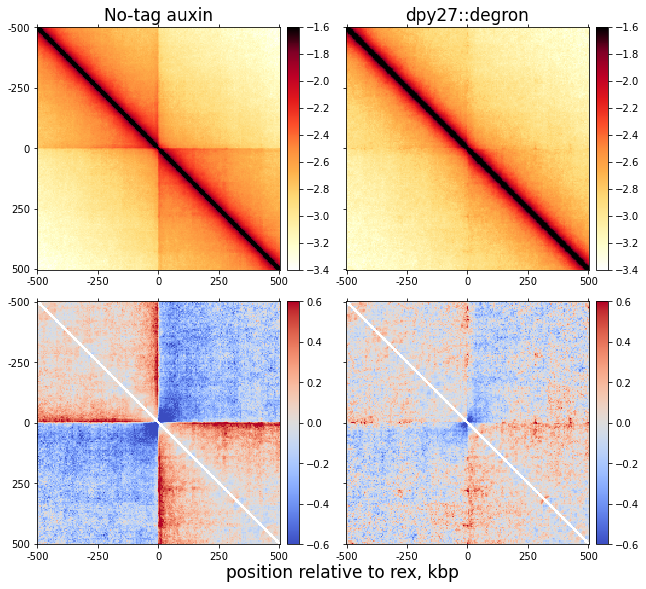

In [62]:
################## rex pileup bw input subt ##############

f, axs = plt.subplots(
    figsize=(9,8),
    ncols=2,nrows=2,
    sharey=True,
    sharex=True)

dat = pileups
# str: layer1=conditions(notag,dpy27), layer=pileup_obs,pileup_obsexp

# global param
minmax_o = [-3.4,-1.6]
minmax_oe = [-0.6,0.6]
sub_titles = ['No-tag auxin','dpy27::degron']
bigFont=17

# ticks, manual ticks
ticks_pixels = np.linspace(0, flank*2//resolution,5) # flank*2//resolution is the total number of ticks on matrix
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int) # label the 5 ticks above



for s in range(len(dat)): # loop thru each condition
    ax = axs[0,s] # first row
    im = ax.matshow(
        np.log10(dat[s][0]), #log10 observed pileup
        cmap='fall',
        vmin=minmax_o[0],vmax=minmax_o[1]
    )
    divider = make_axes_locatable(ax) # make subplot dividable
    cax = divider.append_axes("right", size="5%", pad=0.1) # give 5% of right side of subplot to colorbar
    plt.colorbar(im, cax=cax)
    
    ax = axs[1,s] # second row
    im = ax.matshow(
        np.log2(dat[s][1]), #log2 obs/exp-X pileup
        cmap='coolwarm',
        vmin=minmax_oe[0],vmax=minmax_oe[1]
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
# do some labeling
for i in range(2): 
    axs[0,i].set_title(sub_titles[i],fontsize=bigFont) # put titles
    for j in range(2):
        axs[i,j].set(xticks=ticks_pixels,yticks=ticks_pixels,xticklabels=ticks_kbp,yticklabels=ticks_kbp) # label ticks
        axs[i,j].tick_params(axis='x',which='both',labeltop=False,labelbottom=True) # turn off label at top

    
f.text(0.53, -0.01, 'position relative to rex, kbp', ha='center',fontsize=bigFont)

plt.tight_layout()    